## Download dataset from https://www.kaggle.com/datasets/caxapb/pictures-colorizer/settings

In [2]:
!mkdir /kaggle/working/plots
!mkdir /kaggle/working/models
!mkdir /kaggle/working/results

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.transforms import Normalize

class PictureColorizer(torch.nn.Module):
    def __init__(self):
        super(PictureColorizer, self).__init__()
        self.norm = Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])

        self.conv1 = nn.Conv2d(2, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1, stride=2)
        self.batchnorm1 = nn.BatchNorm2d(64)
        
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1, stride=2)
        self.conv4 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.batchnorm2 = nn.BatchNorm2d(128)
        
        self.conv5 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.batchnorm3 = nn.BatchNorm2d(256)
        
        # Upsampling layers to increase the spatial dimensions
        self.upsample1 = nn.Upsample(scale_factor=2, mode='nearest')
        self.conv6 = nn.Conv2d(256, 128, kernel_size=3, padding=1)
        self.batchnorm4 = nn.BatchNorm2d(128)
        
        self.upsample2 = nn.Upsample(scale_factor=2, mode='nearest')
        self.conv7 = nn.Conv2d(128, 64, kernel_size=3, padding=1)
        self.batchnorm5 = nn.BatchNorm2d(64)
        
        self.conv8 = nn.Conv2d(64, 32, kernel_size=3, padding=1)
        self.conv9 = nn.Conv2d(32, 3, kernel_size=3, padding='same')
        self.batchnorm6 = nn.BatchNorm2d(2)


    def forward(self, x):
        # Initial convolution layers with ReLU activations
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.batchnorm1(x)
        
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.batchnorm2(x)
        
        x = F.relu(self.conv5(x))
        x = self.batchnorm3(x)
        
        # Upsampling and convolution layers with ReLU activations
        x = self.upsample1(x)
        x = F.relu(self.conv6(x))
        x = self.batchnorm4(x)
        
        x = self.upsample2(x)
        x = F.relu(self.conv7(x))
        x = self.batchnorm5(x)
        
        x = F.relu(self.conv8(x))
        
        x = F.relu(self.conv9(x))
        x = self.norm(x)
        x = x - torch.min(x)
        x = x/torch.max(x)
        return x



In [3]:
import cv2
import numpy as np

def transform(img):
    img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    edges = cv2.Canny(img, 100, 200)
    edges = np.expand_dims(edges, axis=2)
    img = np.expand_dims(img, axis=2)
    img = np.append(edges, img, axis=2)
    return img


In [4]:
from torch.utils.data import Dataset
import polars as pl
from torch import Tensor, max
from tqdm import tqdm
from torchvision import transforms
import matplotlib.pyplot as plt
import os
import cv2


class PictureDataset(Dataset):
    def __init__(self, n=1000, image_size=512, path='/kaggle/input/pmldld/pictures/pictures', mode='train'):
        self.n = n
        self.images = [os.path.join(path, mode, img) for img in os.listdir(os.path.join(path, mode))]
        self.resize_transform = transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize((image_size,image_size)),
            transforms.ToTensor(),
        ])

    def __len__(self):
        return int(self.n)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        gray = transform(image)
        image, gray = self.resize_transform(image), self.resize_transform(gray)
        image = image/max(image)
        gray = gray/max(gray)
        return image, gray

In [5]:
import cv2
import numpy as np
from tqdm import tqdm
import torch
import gc
from matplotlib import pyplot as plt
import os


def train_one_epoch(model, loader, optimizer, loss_fn, epoch_num=-1, device='cpu', plotting=False):
    loop = tqdm(
        enumerate(loader),
        total=len(loader),
        desc=f"Epoch {epoch_num}: train",
        leave=True,
    )
    model.train()

    train_loss = 0

    for i, batch in loop:
        colored, gray = batch
        # print(colored.shape, gray.shape)
        colored = colored.to(device)
        gray = gray.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward pass
        outputs = model(gray)

        # loss calculation
        loss = loss_fn(outputs, colored)
        train_loss += loss.item()

        # backward pass
        loss.backward()

        # optimizer run
        optimizer.step()

        if i % 10 == 0:
            gc.collect()

        loop.set_postfix({"loss": float(loss)})

    if plotting:
        print('Train loss:',float(train_loss) / (i+1))
        return float(train_loss) / (i+1)
    return


def val_one_epoch(
    model,
    loader,
    loss_fn,
    best_so_far=0.0,
    best=float("inf"),
    ckpt_path="./models/best.pt",
    epoch_num=-1,
    device='cpu',
    plotting=False,
    visual_progress=False,
):

    loop = tqdm(
        enumerate(loader, 1),
        total=len(loader),
        desc=f"Epoch {epoch_num}: val",
        leave=True,
    )

    val_loss = 0

    with torch.no_grad():
        loss = float("inf")
        model.eval()  # evaluation mode
        for i, batch in loop:
            colored, gray = batch
            colored = colored.to(device)
            gray = gray.to(device)

            # forward pass
            outputs = model(gray)

            # loss calculation
            loss = loss_fn(outputs, colored)
            val_loss += loss.item()

            loop.set_postfix({"mse": float(loss)})

            if i % 10 == 0:
                gc.collect()

        if loss < best_so_far:
            torch.save(model.state_dict(), ckpt_path)
            best_so_far = loss

    if visual_progress and epoch_num % 3 == 0:
        triplet = None
        t1 = gray[0][1].squeeze().cpu()
        t2 = colored[0].permute(1, 2, 0).cpu()
        t3 = outputs[0].permute(1, 2, 0).cpu()
        triplet = (t1, t2, t3)

        fig, axes = plt.subplots(1, 3, figsize=(15, 5))

        axes[0].imshow(triplet[0], cmap='gray')  # Grayscale input
        axes[0].set_title("Input (Grayscale)")

        axes[1].imshow(triplet[1])      # Model output (RGB)
        axes[1].set_title("Truth")

        axes[2].imshow(triplet[2])  # Ground truth (RGB)
        axes[2].set_title("Model Output, epoch " + str(epoch_num))

        directory = 'plots'
        filename = directory + '/visual_progress_epoch_' + str(epoch_num) + '.png'
        plt.savefig(filename)
    print('Val loss:',float(val_loss) / (i+1))
    return best_so_far, float(val_loss) / (i+1)


def train(
    model,
    train_dataloader,
    val_dataloader,
    optimizer,
    loss_fn,
    epochs=10,
    ckpt_path="./models/best.pt",
    device='cpu',
    plotting=False,
):
    best = float("inf")
    prev_best = best
    counter = 0
    losses_train = []
    losses_val = []
    for epoch in range(epochs):
        if plotting:
            loss_train = train_one_epoch(model, train_dataloader, optimizer, loss_fn, epoch_num=epoch,device=device, plotting=True)
            losses_train.append(loss_train)
            best, loss_val = val_one_epoch(
                model,
                val_dataloader,
                loss_fn,
                best_so_far=best,
                ckpt_path=ckpt_path,
                epoch_num=epoch,
                device=device,
                plotting=True,
                visual_progress=True,
            )
            losses_val.append(loss_val)

        else:
            train_one_epoch(model, train_dataloader, optimizer, loss_fn, epoch_num=epoch, device=device)
            best = val_one_epoch(
                model,
                val_dataloader,
                loss_fn,
                best_so_far=best,
                ckpt_path=ckpt_path,
                device=device,
                epoch_num=epoch,
            )

        if prev_best - best <= 0.0000001:
            counter += 1
        else:
            counter = 0
        if best < prev_best:
            prev_best = best
        if counter >= 5:
            break
    if plotting:
        plt.figure(figsize=(10, 5))
        plt.plot(losses_train, label='Training Loss')
        plt.plot(losses_val, label='Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Training and Validation Loss over Epochs')
        plt.legend()

        directory = 'plots'
        filename = directory + '/train_val_loss.png'
        plt.savefig(filename)

Start Train


Epoch 0: train: 100%|██████████| 450/450 [07:09<00:00,  1.05it/s, loss=0.0133] 


Train loss: 0.019211385296657682


Epoch 0: val: 100%|██████████| 50/50 [00:28<00:00,  1.77it/s, mse=0.0165] 


Val loss: 0.015138179136841906


Epoch 1: train: 100%|██████████| 450/450 [06:58<00:00,  1.08it/s, loss=0.00912]


Train loss: 0.014447393657432661


Epoch 1: val: 100%|██████████| 50/50 [00:26<00:00,  1.88it/s, mse=0.0144] 


Val loss: 0.01136557785246302


Epoch 2: train: 100%|██████████| 450/450 [06:58<00:00,  1.08it/s, loss=0.0146] 


Train loss: 0.014690831379137105


Epoch 2: val: 100%|██████████| 50/50 [00:26<00:00,  1.87it/s, mse=0.0143] 


Val loss: 0.011657520279507427


Epoch 3: train: 100%|██████████| 450/450 [06:58<00:00,  1.07it/s, loss=0.016]  


Train loss: 0.013425121783382362


Epoch 3: val: 100%|██████████| 50/50 [00:26<00:00,  1.87it/s, mse=0.0153] 


Val loss: 0.01184531097647314


Epoch 4: train: 100%|██████████| 450/450 [06:58<00:00,  1.08it/s, loss=0.0129] 


Train loss: 0.012294999949841037


Epoch 4: val: 100%|██████████| 50/50 [00:26<00:00,  1.89it/s, mse=0.0143] 


Val loss: 0.010695331419507662


Epoch 5: train: 100%|██████████| 450/450 [06:58<00:00,  1.07it/s, loss=0.00975]


Train loss: 0.012035573309080469


Epoch 5: val: 100%|██████████| 50/50 [00:26<00:00,  1.85it/s, mse=0.0134] 


Val loss: 0.01034960581683645


Epoch 6: train: 100%|██████████| 450/450 [06:58<00:00,  1.07it/s, loss=0.0133] 


Train loss: 0.011497367662895056


Epoch 6: val: 100%|██████████| 50/50 [00:26<00:00,  1.85it/s, mse=0.0156] 


Val loss: 0.011303848376972419


Epoch 7: train: 100%|██████████| 450/450 [07:00<00:00,  1.07it/s, loss=0.00841]


Train loss: 0.011645105900242925


Epoch 7: val: 100%|██████████| 50/50 [00:26<00:00,  1.86it/s, mse=0.0121] 


Val loss: 0.010247283149510622


Epoch 8: train: 100%|██████████| 450/450 [06:58<00:00,  1.08it/s, loss=0.00871]


Train loss: 0.011446696541065143


Epoch 8: val: 100%|██████████| 50/50 [00:26<00:00,  1.86it/s, mse=0.0166] 


Val loss: 0.011757669568646188


Epoch 9: train: 100%|██████████| 450/450 [06:58<00:00,  1.08it/s, loss=0.00863]


Train loss: 0.011175229773960179


Epoch 9: val: 100%|██████████| 50/50 [00:26<00:00,  1.87it/s, mse=0.0133] 


Val loss: 0.010944406501948833


Epoch 10: train: 100%|██████████| 450/450 [06:58<00:00,  1.08it/s, loss=0.00919]


Train loss: 0.010913440437159605


Epoch 10: val: 100%|██████████| 50/50 [00:26<00:00,  1.87it/s, mse=0.0119] 


Val loss: 0.009851940551444012


Epoch 11: train: 100%|██████████| 450/450 [06:58<00:00,  1.07it/s, loss=0.00628]


Train loss: 0.010859689387596317


Epoch 11: val: 100%|██████████| 50/50 [00:26<00:00,  1.87it/s, mse=0.0125] 


Val loss: 0.009891583502073498


Epoch 12: train: 100%|██████████| 450/450 [06:59<00:00,  1.07it/s, loss=0.0109] 


Train loss: 0.01060001583614697


Epoch 12: val: 100%|██████████| 50/50 [00:27<00:00,  1.81it/s, mse=0.0122] 


Val loss: 0.00951796792922359


Epoch 13: train: 100%|██████████| 450/450 [06:59<00:00,  1.07it/s, loss=0.0126] 


Train loss: 0.010690605659037828


Epoch 13: val: 100%|██████████| 50/50 [00:26<00:00,  1.86it/s, mse=0.0144] 


Val loss: 0.010247042904808825


Epoch 14: train: 100%|██████████| 450/450 [06:58<00:00,  1.08it/s, loss=0.0109] 


Train loss: 0.01070392581841184


Epoch 14: val: 100%|██████████| 50/50 [00:26<00:00,  1.87it/s, mse=0.0126] 


Val loss: 0.009646301787784872


Epoch 15: train: 100%|██████████| 450/450 [06:58<00:00,  1.08it/s, loss=0.0109] 


Train loss: 0.010570991365756425


Epoch 15: val: 100%|██████████| 50/50 [00:26<00:00,  1.86it/s, mse=0.013]  


Val loss: 0.009576238436149615


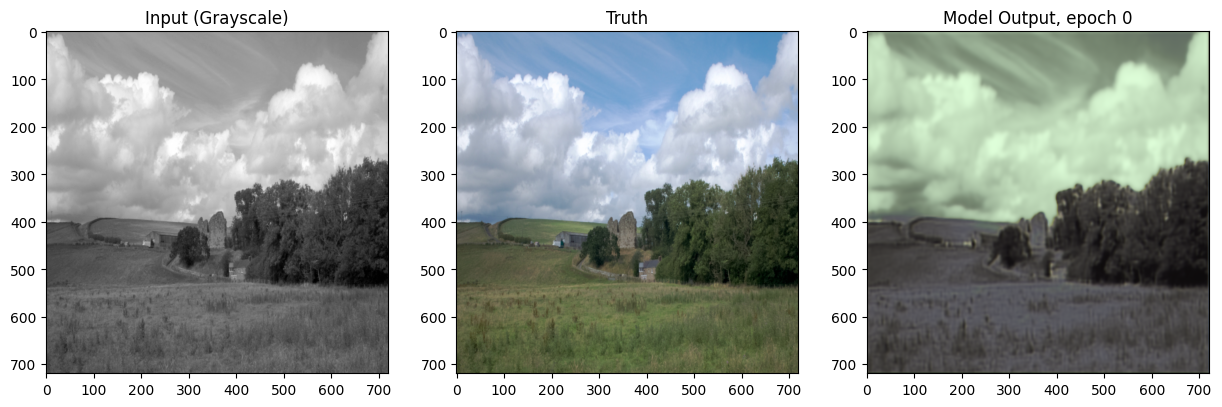

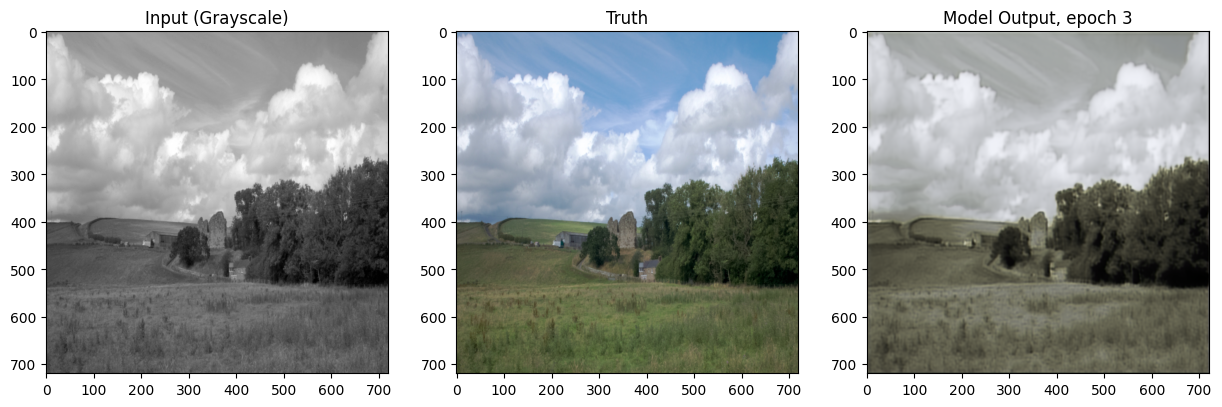

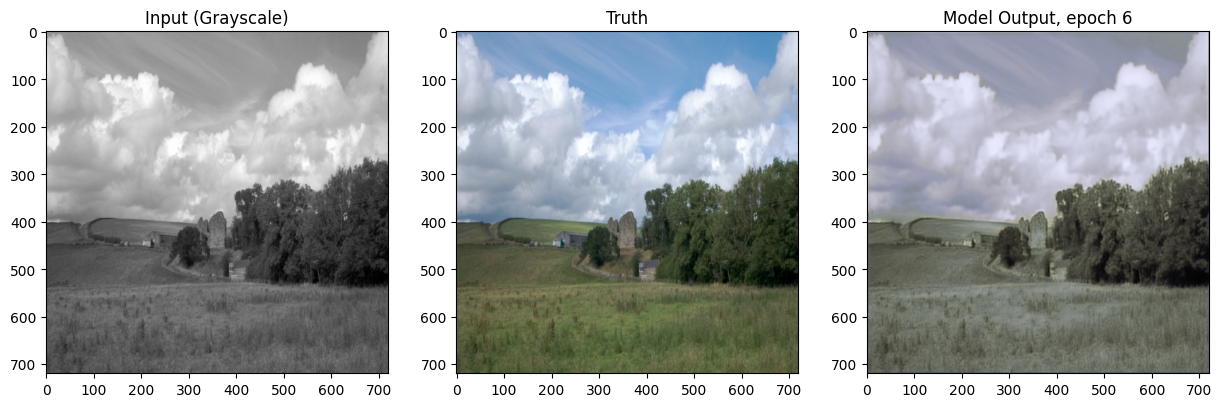

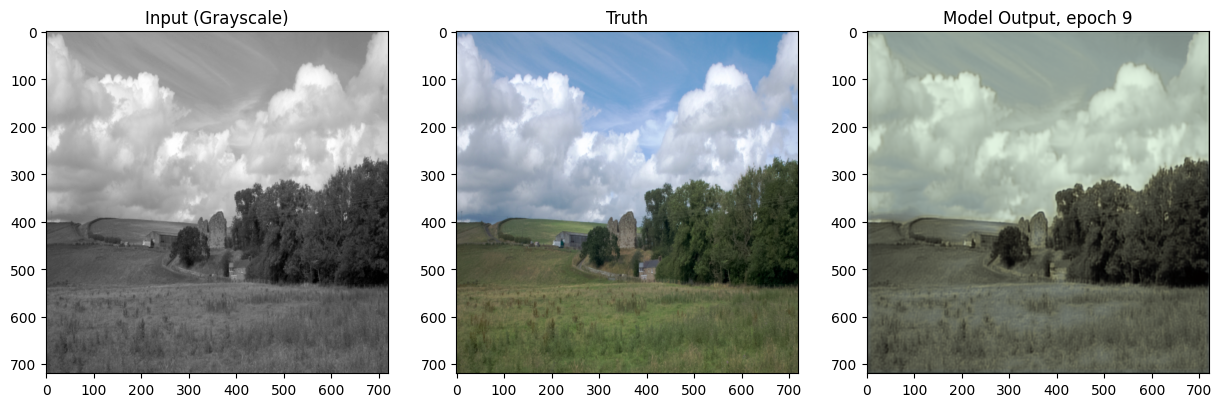

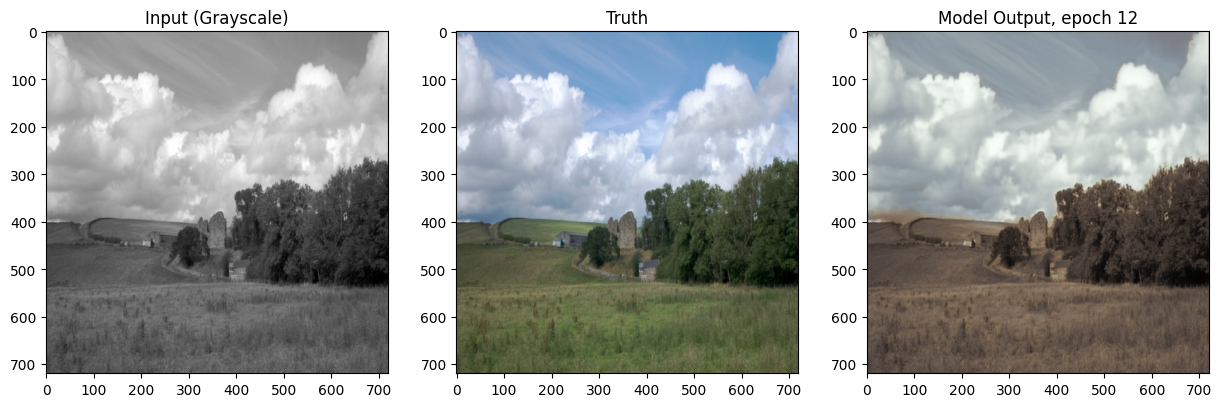

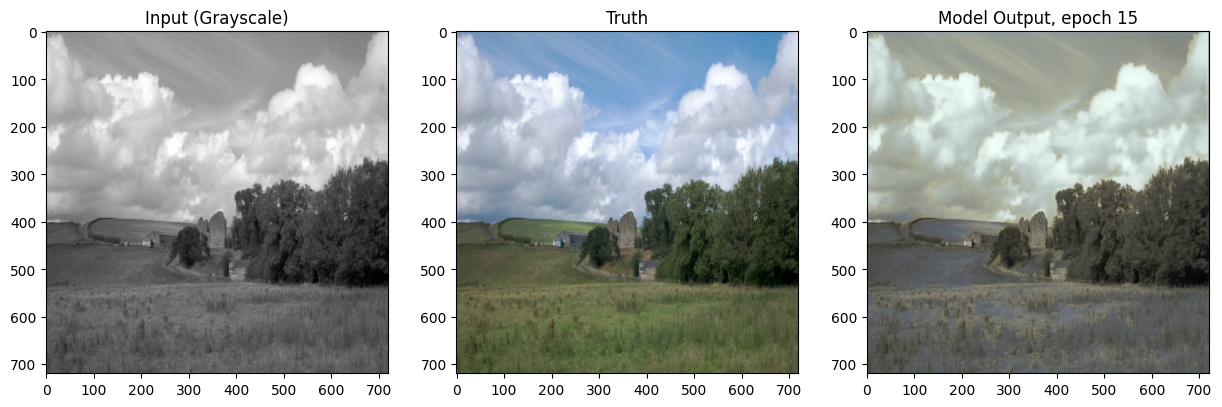

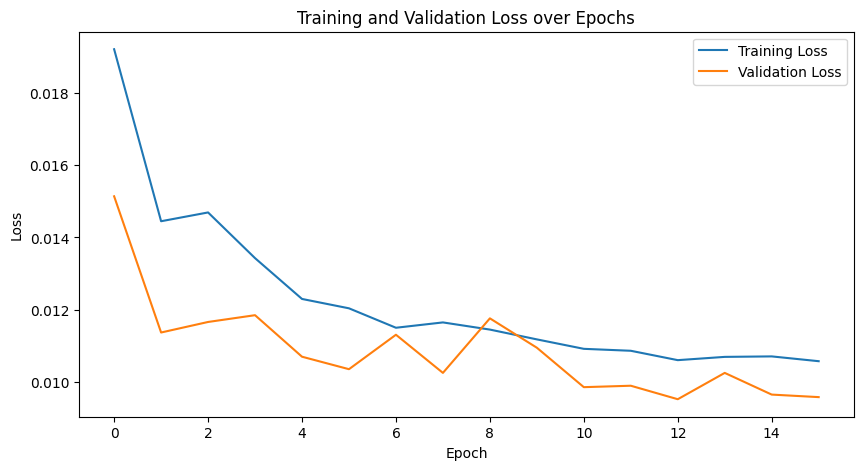

In [7]:
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
import torch
import torch.optim as optim
import pickle
import os


validation_ratio = 0.1
total = 2000

val_dataset = PictureDataset(n=validation_ratio*total, image_size = 720, mode='val')
train_dataset = PictureDataset(n=(1-validation_ratio)*total, image_size = 720, mode='train')

batch_size = 4
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

device = 'cuda'
model = PictureColorizer().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_fn = torch.nn.MSELoss()
epochs = 30
ckpt_path = '/kaggle/working/best_model.pt'
print("Start Train")

train(model, train_dataloader, val_dataloader, optimizer, loss_fn, epochs, ckpt_path=ckpt_path, device=device, plotting=True)

torch.save(model.state_dict(), ckpt_path)


In [6]:
import cv2
import numpy as np
from tqdm import tqdm
import torch
import gc
from matplotlib import pyplot as plt
import os

def train_one_epoch(model, loader, optimizer, loss_fn, epoch_num=-1, device='cpu', plotting=False):
    loop = tqdm(
        enumerate(loader),
        total=len(loader),
        desc=f"Epoch {epoch_num}: train",
        leave=True,
    )
    model.train()
    train_loss = 0
    for i, batch in loop:
        colored, gray = batch
        colored = colored.to(device)
        gray = gray.to(device)
        optimizer.zero_grad()
        outputs = model(gray)
        loss = loss_fn(outputs, colored)
        train_loss += loss.item()
        loss.backward()
        optimizer.step()
        if i % 10 == 0:
            gc.collect()
        loop.set_postfix({"loss": float(loss)})
    if plotting:
        print('Train loss:', float(train_loss) / (i+1))
        return float(train_loss) / (i+1)
    return

def val_one_epoch(
    model,
    loader,
    loss_fn,
    best_so_far=0.0,
    best=float("inf"),
    ckpt_path="./models/best.pt",
    epoch_num=-1,
    device='cpu',
    plotting=False,
    visual_progress=False,
):
    loop = tqdm(
        enumerate(loader, 1),
        total=len(loader),
        desc=f"Epoch {epoch_num}: val",
        leave=True,
    )
    val_loss = 0
    with torch.no_grad():
        model.eval()
        for i, batch in loop:
            colored, gray = batch
            colored = colored.to(device)
            gray = gray.to(device)
            outputs = model(gray)
            loss = loss_fn(outputs, colored)
            val_loss += loss.item()
            loop.set_postfix({"mse": float(loss)})
            if i % 10 == 0:
                gc.collect()
        if val_loss < best_so_far:
            torch.save(model.state_dict(), ckpt_path)
            best_so_far = val_loss
    if visual_progress and epoch_num % 3 == 0:
        triplet = (gray[0][1].squeeze().cpu(), colored[0].permute(1, 2, 0).cpu(), outputs[0].permute(1, 2, 0).cpu())
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))
        axes[0].imshow(triplet[0], cmap='gray')
        axes[0].set_title("Input (Grayscale)")
        axes[1].imshow(triplet[1])
        axes[1].set_title("Truth")
        axes[2].imshow(triplet[2])
        axes[2].set_title("Model Output, epoch " + str(epoch_num + 45))
        directory = 'plots'
        filename = directory + '/visual_progress_epoch_' + str(epoch_num  + 45) + '.png'
        plt.savefig(filename)
    print('Val loss:', float(val_loss) / (i+1))
    return best_so_far, float(val_loss) / (i+1)

def train(
    model,
    train_dataloader,
    val_dataloader,
    optimizer,
    loss_fn,
    epochs=10,
    ckpt_path="./models/best.pt",
    device='cpu',
    plotting=False,
):
    best = float("inf")
    losses_train = []
    losses_val = []
    
    # Load last saved weights
    if os.path.exists(ckpt_path):
        model.load_state_dict(torch.load(ckpt_path))
        print("Loaded model weights from last checkpoint.")

    for epoch in range(epochs):
        if plotting:
            loss_train = train_one_epoch(model, train_dataloader, optimizer, loss_fn, epoch_num=epoch, device=device, plotting=True)
            losses_train.append(loss_train)
            best, loss_val = val_one_epoch(
                model,
                val_dataloader,
                loss_fn,
                best_so_far=best,
                ckpt_path=ckpt_path,
                epoch_num=epoch,
                device=device,
                plotting=True,
                visual_progress=True,
            )
            losses_val.append(loss_val)
        else:
            train_one_epoch(model, train_dataloader, optimizer, loss_fn, epoch_num=epoch, device=device)
            best = val_one_epoch(
                model,
                val_dataloader,
                loss_fn,
                best_so_far=best,
                ckpt_path=ckpt_path,
                epoch_num=epoch,
                device=device,
            )
    if plotting:
        plt.figure(figsize=(10, 5))
        plt.plot(losses_train, label='Training Loss')
        plt.plot(losses_val, label='Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Training and Validation Loss over Epochs')
        plt.legend()
        directory = 'plots'
        filename = directory + '/train_val_loss.png'
        plt.savefig(filename)

# Example usage
from torch.utils.data import DataLoader
import torch.optim as optim

validation_ratio = 0.1
total = 2000
val_dataset = PictureDataset(n=validation_ratio*total, image_size=720, mode='val')
train_dataset = PictureDataset(n=(1-validation_ratio)*total, image_size=720, mode='train')
batch_size = 4
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
device = 'cuda'
model = PictureColorizer().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_fn = torch.nn.MSELoss()
epochs = 30
ckpt_path = '/kaggle/working/best_model.pt'
print("Start Train from 15")
train(model, train_dataloader, val_dataloader, optimizer, loss_fn, epochs, ckpt_path=ckpt_path, device=device, plotting=True)
torch.save(model.state_dict(), ckpt_path)


NameError: name 'PictureColorizer' is not defined